# Data Cleaning Project: Air Quality

Tu as reçu un mail de ton manager qui te dit : "Télécharge le jeu de données disponible sur la plateforme Opendatasoft (openaq.csv). Et renvoie-moi d'ici la fin de la journée un fichier csv qui ne comporte aucune erreur, ni information non exploitable. Merci et bon courage."

Disclaimers:  
- Some records contain encoding issues on specific characters; those issues are present in the raw API data and were not corrected.  
- Some dates are set in the future: those issues also come from the original data and were not corrected. 

In [1]:
# Importer les bibliothèques et récupérer le fichier
import pandas as pd
import numpy as np

air_quality = pd.read_csv("air_quality.csv", delimiter=";", encoding="utf-8")

# Afficher les premières lignes
air_quality.head()

Country Code                City               Location  \
0           DE        Manfred Lotz  Cottbus, W.-Külz-Str.   
1           ES  Castellón/Castelló                ES1969A   
2           ES   Valencia/València                ES1885A   
3           ES    Alicante/Alacant                ES2008A   
4           ES    Alicante/Alacant                ES1968A   

                 Coordinates Pollutant  Source Name   Unit  Value  \
0         51.75413,14.325549     PM2.5  EEA Germany  µg/m³   21.7   
1  39.8236111095,-0.24444444       NO2    EEA Spain  µg/m³    1.0   
2  39.4802777695,-0.33638888       SO2    EEA Spain  µg/m³    5.0   
3        37.9911111095,-0.69     PM2.5    EEA Spain  µg/m³    9.0   
4  38.3511111095,-0.51388888      PM10    EEA Spain  µg/m³    1.0   

                Last Updated Country Label  
0  2016-12-21T12:00:00+01:00       Germany  
1  2021-07-13T08:00:00+02:00         Spain  
2  2021-08-06T11:00:00+02:00         Spain  
3  2021-08-06T11:00:00+02:00         Spain  
4  2021-08-06T11:00:00+02:00         Spain

In [2]:
# Check the presence of missing values in the dataframe
print(air_quality.isnull().sum())

Country Code        0
City              107
Location            4
Coordinates      2444
Pollutant           0
Source Name         0
Unit                0
Value               0
Last Updated        0
Country Label      60
dtype: int64


#### 1) Supprimer les données qui ne concernent pas la journée du 06-08-2021.

In [3]:
# Filter only the data concerning dates starting with '2021-08-06'
air_quality = air_quality.loc[air_quality['Last Updated'].str.startswith('2021-08-06')]

air_quality.head()

Country Code               City Location                Coordinates  \
2           ES  Valencia/València  ES1885A  39.4802777695,-0.33638888   
3           ES   Alicante/Alacant  ES2008A        37.9911111095,-0.69   
4           ES   Alicante/Alacant  ES1968A  38.3511111095,-0.51388888   
5           ES  Valencia/València  ES1911A  39.7052777695,-0.33666666   
6           ES  Valencia/València  ES1185A  39.6672222195,-0.23472222   

  Pollutant Source Name   Unit  Value               Last Updated Country Label  
2       SO2   EEA Spain  µg/m³    5.0  2021-08-06T11:00:00+02:00         Spain  
3     PM2.5   EEA Spain  µg/m³    9.0  2021-08-06T11:00:00+02:00         Spain  
4      PM10   EEA Spain  µg/m³    1.0  2021-08-06T11:00:00+02:00         Spain  
5        CO   EEA Spain  µg/m³  100.0  2021-08-06T11:00:00+02:00         Spain  
6      PM10   EEA Spain  µg/m³   13.0  2021-08-06T11:00:00+02:00         Spain

#### 2) Supprimer les données qui sont illisibles et pour lesquelles on ne comprend pas la ville concernée.

In [4]:
print(f"Nombre de lignes avant nettoyage : {len(air_quality)}")

# Remove lines that are not being encoded and decoded properly by UTF-8 format
air_quality = air_quality.applymap(lambda x: x.encode('utf-8', 'ignore').decode('utf-8', 'ignore') if isinstance(x, str) else x)
air_quality = air_quality.dropna()

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

Nombre de lignes avant nettoyage : 24287
Nombre de lignes après nettoyage : 24192


In [5]:
# Check the presence of missing values in the dataframe
print(air_quality.isnull().sum())

Country Code     0
City             0
Location         0
Coordinates      0
Pollutant        0
Source Name      0
Unit             0
Value            0
Last Updated     0
Country Label    0
dtype: int64


#### 3) Pour chaque polluant, vérifier qu'on n'a qu'une seule mesure utilisée. Autrement, supprimer les données qui correspondent à la mesure minoritaire ou moins cohérente.

Si on comprend la question en terme de valeur de la mesure :

In [6]:
print(f"Nombre de lignes avant nettoyage : {len(air_quality)}")

# Get the maximum pollutant value recorded for each pollutant and city combination.
PollutantCount = air_quality.groupby(['Pollutant','City'])['Value'].max()

# Inner join of the two dataframes : filters out all rows where the pollutant value is not the 
# maximum value for that pollutant and city combination.
air_quality = pd.merge(air_quality, PollutantCount, on=['Pollutant', 'City', 'Value'], how='inner')

# Delete duplicates based on the combinaison of columns 'Pollutant', 'City' and 'Value', 
# thus eliminating the cases of several maximum values.
air_quality.drop_duplicates(subset=['Pollutant', 'City', 'Value'], inplace=True)

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

air_quality.head()

Nombre de lignes avant nettoyage : 24192
Nombre de lignes après nettoyage : 7933


Country Code              City Location                Coordinates  \
0           ES  Alicante/Alacant  ES2008A        37.9911111095,-0.69   
1           ES  Alicante/Alacant  ES1849A      38.2591666595,-0.7175   
7           ES           Almería  ES1835A     36.9499999995,-1.96148   
8           ES            Huelva  ES0787A     37.1903299995,-6.90453   
9           ES           Bizkaia  ES1491A  43.4061111095,-2.70388888   

  Pollutant Source Name   Unit  Value               Last Updated Country Label  
0     PM2.5   EEA Spain  µg/m³    9.0  2021-08-06T11:00:00+02:00         Spain  
1        CO   EEA Spain  µg/m³  100.0  2021-08-06T11:00:00+02:00         Spain  
7        CO   EEA Spain  µg/m³  417.0  2021-08-06T09:00:00+02:00         Spain  
8       SO2   EEA Spain  µg/m³   41.0  2021-08-06T08:00:00+02:00         Spain  
9        O3   EEA Spain  µg/m³   54.0  2021-08-06T04:00:00+02:00         Spain

Si on comprend la question en terme d'unité de mesure :

In [7]:
# Check the units used for each pollutant and count the values
pollutant_unit = air_quality.groupby(["Pollutant","Unit"]).size()
print(pollutant_unit)

# Display the last rows of the dataframe
air_quality.tail()

Pollutant  Unit 
BC         µg/m³      69
CO         ppm       169
           µg/m³     670
NO2        ppm       216
           µg/m³    1192
O3         ppm       601
           µg/m³    1090
PM10       µg/m³    1370
PM2.5      µg/m³    1505
SO2        ppm       224
           µg/m³     827
dtype: int64


Country Code               City                               Location  \
8522           TH         Chiang Rai                   Maesai Health Office   
8523           TH  Nakhon Ratchasima  Municipal Waste Water Pumping Station   
8524           TH       Nakhon Sawan         Nakhonsawan Irrigation Project   
8525           TH       Chachoengsao          Municipality Office Tungsadao   
8526           TH       Chachoengsao          Municipality Office Tungsadao   

               Coordinates Pollutant Source Name   Unit   Value  \
8522   20.427325,99.883842        O3    Air4Thai    ppm   0.023   
8523  14.979726,102.098301        O3    Air4Thai    ppm   0.028   
8524  15.686254,100.110542        O3    Air4Thai    ppm   0.021   
8525  13.588554,101.286359      PM10    Air4Thai  µg/m³  37.000   
8526  13.588554,101.286359        O3    Air4Thai    ppm   0.016   

                   Last Updated Country Label  
8522  2021-08-06T14:00:00+02:00      Thailand  
8523  2021-08-06T14:00:00+02:00      Thailand  
8524  2021-08-06T14:00:00+02:00      Thailand  
8525  2021-08-06T13:00:00+02:00      Thailand  
8526  2021-08-06T13:00:00+02:00      Thailand

In [8]:
# Remove all rows where the pollutant values are in ppm
air_quality = air_quality.loc[~((air_quality["Pollutant"] == "CO") & (air_quality["Unit"] == "ppm"))]
air_quality = air_quality.loc[~((air_quality["Pollutant"] == "NO2") & (air_quality["Unit"] == "ppm"))]
air_quality = air_quality.loc[~((air_quality["Pollutant"] == "O3") & (air_quality["Unit"] == "ppm"))]
air_quality = air_quality.loc[~((air_quality["Pollutant"] == "SO2") & (air_quality["Unit"] == "ppm"))]

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

# Print the new table (without ppm units)
pollutant_unit = air_quality.groupby(["Pollutant","Unit"]).size()
print(pollutant_unit)

# Display the last rows of the dataframe
air_quality.tail()

Nombre de lignes après nettoyage : 6723
Pollutant  Unit 
BC         µg/m³      69
CO         µg/m³     670
NO2        µg/m³    1192
O3         µg/m³    1090
PM10       µg/m³    1370
PM2.5      µg/m³    1505
SO2        µg/m³     827
dtype: int64


Country Code               City                       Location  \
8518           PT            Setúbal                        PT04003   
8519           PT    Ilha da Madeira                        PT06004   
8520           PT   Viana do Castelo                        PT01047   
8521           SK  Bratislavský kraj                        SK0002A   
8525           TH       Chachoengsao  Municipality Office Tungsadao   

                  Coordinates Pollutant   Source Name   Unit     Value  \
8518      37.871111,-8.723889        O3  EEA Portugal  µg/m³   76.0000   
8519     32.648889,-16.883056        CO  EEA Portugal  µg/m³  285.0000   
8520      41.802222,-8.693889        O3  EEA Portugal  µg/m³   64.0000   
8521  48.1584279995,17.128678       NO2  EEA Slovakia  µg/m³   28.0223   
8525     13.588554,101.286359      PM10      Air4Thai  µg/m³   37.0000   

                   Last Updated Country Label  
8518  2021-08-06T12:00:00+02:00      Portugal  
8519  2021-08-06T11:00:00+02:00      Portugal  
8520  2021-08-06T09:00:00+02:00      Portugal  
8521  2021-08-06T13:00:00+02:00      Slovakia  
8525  2021-08-06T13:00:00+02:00      Thailand

In [9]:
# Save the cleaned data in a new csv file
air_quality.to_csv('air_quality_cleaned.csv', index=False)

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

Nombre de lignes après nettoyage : 6723


#### 4) Regarder s'il y a des valeurs aberrantes ou des problèmes par rapport à notre objectif final (pouvoir comparer des mesures sur un maximum de pays) et noter ces aspects dans un fichier texte.

In [10]:
# ---------------- Method 1: Z-scores
import numpy as np

# Calculate z-scores for CO pollutant values in Spain
spain_CO_zscore = (air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'] - 
                   air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'].mean()) / \
                  air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'].std()

# Define threshold for identifying outliers
threshold = 2

# Create new dataframe with outliers for CO pollutant values in Spain
spain_CO_outliers = air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')][np.abs(spain_CO_zscore) > threshold]

# Print the new dataframe
display(spain_CO_outliers)

Country Code    City Location             Coordinates Pollutant  \
1335           ES   Cádiz  ES1593A  36.4605899995,-6.20307        CO   
3417           ES  Málaga  ES2030A    36.5109999995,-4.863        CO   

     Source Name   Unit   Value               Last Updated Country Label  
1335   EEA Spain  µg/m³  1372.0  2021-08-06T08:00:00+02:00         Spain  
3417   EEA Spain  µg/m³  1273.0  2021-08-06T08:00:00+02:00         Spain

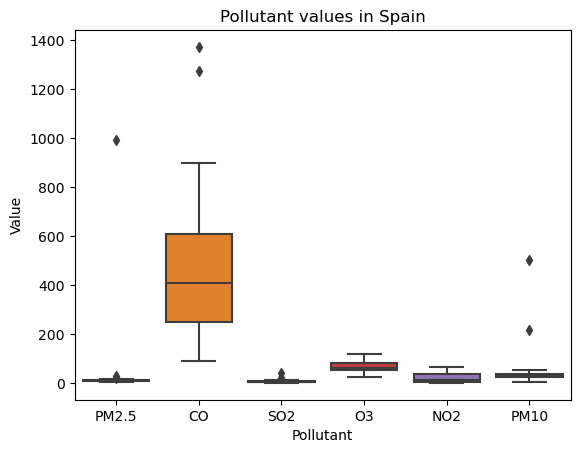

In [11]:
# ---------------- Method 2: Box plot
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for Spain
spain_data = air_quality[air_quality['Country Code'] == 'ES']

# Create the box plot using seaborn
sns.boxplot(x='Pollutant', y='Value', data=spain_data)

# Set the title and axis labels
plt.title('Pollutant values in Spain')
plt.xlabel('Pollutant')
plt.ylabel('Value')

# Show the plot
plt.show()